<a href="https://colab.research.google.com/github/Samuraiwarm/google-colab-bookmarks/blob/master/Copy_of_Text_classification_NBSVM_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent classification
In this lab, you will work on intent classification of phone calls using NBSVM and its variant. Data is provided courtesy of TrueVoice and should be used for education purposes only. The data have been anonymized. 

## Download the dataset


In [0]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
!head clean-phone-data-for-students.csv

--2019-09-21 07:13:28--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv [following]
--2019-09-21 07:13:29--  https://www.dropbox.com/s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc21252a1a331ba116e1fc9fa37.dl.dropboxusercontent.com/cd/0/inline/Ao8QCz08T61YUB3IgxswXKKX-thS57L201JP65D7hUlu2mszE0-PicGTPd0kytECQ27egOz3wyP4ZPmFimfk8Ey7nrkEnVuRwk6Q-MZbMwBHpA/file# [following]
--2019-09-21 07:13:29--  https://ucc21252a1a331ba116e1fc9fa37.dl.dropboxusercontent.com/cd/0/inline/Ao8QCz08T61YUB3IgxswXKKX-thS57L201JP65D7hUlu2mszE0-PicGTPd0kytECQ27egOz3

## Import Libs

In [0]:
!pip install pythainlp

In [0]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pythainlp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

**Note: the data is provided courtesy of TrueVoice and must be used for educational purposes only**

In [0]:
phone_df = pd.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [0]:
# Show the top 5 rows
display(phone_df.head())
# Summarize the data
phone_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We first select only the columns we are interested.

For this example we will be training a model to predict the "Object" given a "Sentence Utterance". Thus we will be only selecting these two. Others can also be selected, but these two will serve as an example.

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

In [0]:
data_df = phone_df[["Sentence Utterance", "Object"]]
data_df.columns = ['input', 'raw_label']
display(data_df.describe())
display(data_df.raw_label.unique())

,input,raw_label
count,16175,16175
unique,13389,33
top,บริการอื่นๆ,service
freq,97,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

### Removing duplicated labels

from above, we can see that there are 33 unique labels

But we want to make sure that these label are really unique from one another not just how capital letters are used

In [0]:
data_df['clean_label']=data_df['raw_label'].str.lower().copy()
display(data_df.describe())
display(data_df.clean_label.unique())



,input,raw_label,clean_label
count,16175,16175,16175
unique,13389,33,26
top,บริการอื่นๆ,service,service
freq,97,2525,2528


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [0]:
#we no longer need raw_label column
data_df.drop('raw_label', axis=1, inplace=True)
display(data_df.describe())

,input,clean_label
count,16175,16175
unique,13389,26
top,บริการอื่นๆ,service
freq,97,2528


### Remove duplicates input

There are some duplicates in the input of this dataset.

In [0]:
display(data_df[data_df.duplicated(keep=False)]['input'])

18       <PHONE_NUMBER_REMOVED> เป็นหมายเลขของเครือข่าย...
19       <PHONE_NUMBER_REMOVED> เป็นหมายเลขของเครือข่าย...
35       <PHONE_NUMBER_REMOVED> เป็นเติมเงินนะคะ เดี๋ยว...
36       <PHONE_NUMBER_REMOVED> เป็นเติมเงินนะคะ เดี๋ยว...
52               3g wifi edge ตอนนี้มีโปรโมชั่นอะไรบ้างค่ะ
53               3g wifi edge ตอนนี้มีโปรโมชั่นอะไรบ้างค่ะ
54               3g wifi edge ตอนนี้มีโปรโมชั่นอะไรบ้างค่ะ
73                   iphone ย้ายค่ายจะใช้โปร 799 ได้ไหมค่ะ
74                   iphone ย้ายค่ายจะใช้โปร 799 ได้ไหมค่ะ
75                   iphone ย้ายค่ายจะใช้โปร 799 ได้ไหมค่ะ
78                  sim ของผมมันหักตังมันสมัครอะไรอยู่ครับ
79                  sim ของผมมันหักตังมันสมัครอะไรอยู่ครับ
80                                         sim มันล็อคครับ
81                                         sim มันล็อคครับ
85                                   swap แมค เป็น แอด แมค
86                                   swap แมค เป็น แอด แมค
114      เคยโทรไปแจ้งปัญหาเกี่ยวกับโบนัสอ่ะค่ะ เขาบอกว่.

As you can see above, we no longer have unwanted duplicated in our labels

But there are still duplicates in our input. 7 rows with "สอบถามยอดค้างชำระค่ะ"

We will remove them now, by keeping only the first entry.

In [0]:
data_df = data_df.drop_duplicates("input", keep="first")
display(data_df.describe())

,input,clean_label
count,13389,13389
unique,13389,26
top,อยากทราบว่าบิลที่เค้าแจ้งมา ต้องจ่ายไปก่อนหรือ...,service
freq,1,2111


### Convert to one-hot 

In [0]:
data_df['clean_label'] = pd.Categorical(data_df['clean_label'])
dfDummies = pd.get_dummies(data_df['clean_label'])
data_df=pd.concat([data_df,dfDummies], axis=1)

### Trim whitestring

In [0]:
data_df['input'] = data_df['input'].apply(lambda x: x.strip() )

In [0]:
unique_label = data_df.clean_label.unique()

### Visualize Class Count

We will now visualize the class imbalance. Note that training directly on imbalance dataset can yield bad results. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


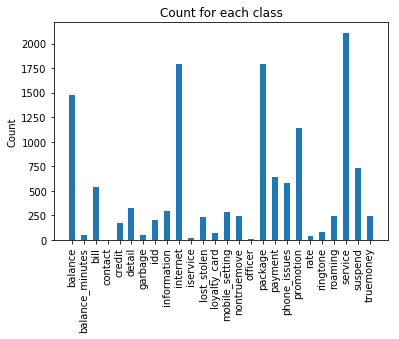

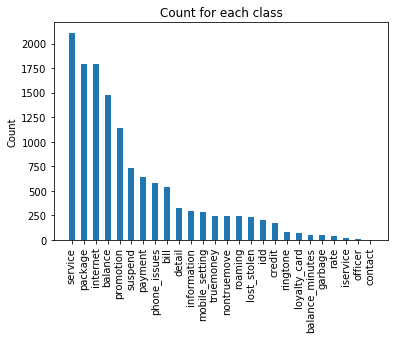

In [0]:
def plot(label, count):
    fig, ax = plt.subplots()
    ind = np.arange(len(count))
    rects1 = ax.bar(ind, count, 0.5)

    ax.set_ylabel('Count')
    ax.set_title('Count for each class')
    ax.set_xticks(ind)
    ax.set_xticklabels(label,rotation='vertical')

    plt.show()
data = np.array(data_df.as_matrix(), copy=True)  
label, count = np.unique(data[:, 1], return_counts=True)
plot(label, count)

# pack the label and count together
bundle = list(zip(label, count))
# sort them by count
bundle = sorted(bundle, key=lambda e: e[1], reverse=True) 
# unpack the values
label, count = zip(*bundle)
plot(label, count)

### Split data

split data into train and test set 

In [0]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_df,stratify=data_df['clean_label'], test_size=0.2,random_state=42)

In [0]:
#we no longer need clean_label column
train_data.drop('clean_label', axis=1, inplace=True)
test_data.drop('clean_label', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Feature Engineering for NBSVM 

"Feature Engineering" is just a fancy word for making the input work with our model.

The models that we are going to tackle do not accpet varying size input, so we have to transform our input in some ways that makes the input have this property while also retaining some useful information.

NBSVM (Naive Bayes - Support Vector Machine) was introduced by Sida Wang and Chris Manning in the paper Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation. In this lab, we will show you how to implement NBSVM to create a strong baseline.


reference: https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

### Feature #1:  bag of words representation, as a TFIDF matrix
In the original paper, the authors use word bigram features.  A Kaggler, Jeremy Howard, found that TFIDF features could give a better performance over  word bigram features.   

## Exercise 1:  Create TFIDF features
* choose a suitable tokenizer for TfidfVectorizer
*  fit tfidfVectorizer on the training data
*  transform raw text to tdidf features on the training data
*  transform raw text to tdidf features on the test data


In [0]:
n = len(train_data['input'])
#Exercise 1
# tokenizer = ######FILL YOUR CODE HERE ######
tokenizer = pythainlp.tokenize.word_tokenize
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenizer,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

#  fit tfidfVectorizer on the training data
# transform raw text to tdidf features on the training data
# x = ######FILL YOUR CODE HERE ######
x = vec.fit_transform(train_data['input'])
#  transform raw text to tdidf features on the test data
# test_x = ######FILL YOUR CODE HERE ######
test_x = vec.transform(test_data['input'])

x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Exercise 1: solution

In [0]:
n = len(train_data['input'])
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=pythainlp.word_tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
#  fit tfidfVectorizer on the training data
# transform raw text to tdidf features on the training data
x = vec.fit_transform(train_data['input'])
#  transform raw text to tdidf features on the test data
test_x = vec.transform(test_data['input'])


### Feature #2: Naive-Bayes Feature
*   $\mathbf{f}^{(i)} \in \mathbb{R}^{|V|}$ = the feature count vector for
training case $i$ with label      $y^{(i)} \in\{0,1\}$
* $V$ = sets of features
* $\mathbf{f}_{j}^{(i)}$ =  the number of occurrences of feature $V_{j}$ in training case $i$
*  the count vectors $\mathbf{p}=\alpha+\sum_{i : y^{(i)}=1} \mathbf{f}^{(i)}$    and   $\mathbf{q}=\alpha+\sum_{i : y^{(i)}=0} \mathbf{f}^{(i)}$ ($\alpha$ is the smoothing parameter (let $\alpha=1$ in this lab))
           
* log-count ratio: $\mathbf{r}=\log \left(\frac{\mathbf{p} /\|\mathbf{p}\|_{1}}{\mathbf{q} /\|\mathbf{q}\|_{1}}\right)$

## Exercise #2: log-count ratio
Complete a function that returns numerator or denominator of the log-count ratio $r$
> def pr(y_i, y):


In [0]:
def pr(y_i, y):
    #####FILL YOUR CODE HERE#####
    alpha = 1
    p = x[y==y_i].sum(0)
    return (p+alpha) / (p+alpha).sum()
    # pass#REMOVE THIS LINE

#### Exercise 2: solution

In [0]:
def pr(y_i, y):
    alpha = 1
    p = x[y==y_i].sum(0)
    return (p+alpha) / (p+alpha).sum()

###  Fit a model for one dependent at a time:
In this lab, we are going to train NBSVM as well as a faster/simpler NBLR by replacing an SVM component with a Logistic Regression model.

NBSVM is almost identical to the SVM, except that the input feature is the element-wise product between  the input feature (TF-IDF in this experiment) and the log-count ratio.

$\mathbf{r}=\log \left(\frac{\mathbf{p} /\|\mathbf{p}\|_{1}}{\mathbf{q} /\|\mathbf{q}\|_{1}}\right)$

In [0]:
def get_mdl_nbsvm(y):
    ### FILL YOUR CODE HERE ###
    y = y.values
    r = np.log(pr(1,y)/pr(0,y))
    m = svm.SVC(gamma='scale', probability=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r


def get_mdl_nblr(y):
    ### FILL YOUR CODE HERE ###
    y = y.values
    r = np.log(pr(1,y)/pr(0,y))
    m = LogisticRegression(C=4,max_iter=200,dual=True,solver='liblinear',random_state=42)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r


#### Exercise 3: solution

In [0]:
def get_mdl_nbsvm(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y)) #log-count ratio
    m = svm.SVC(gamma='scale',probability=True)
    x_nb = x.multiply(r) #tfidf * r
    return m.fit(x_nb, y), r


def get_mdl_nblr(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y)) #log-count ratio
    m = LogisticRegression(C=4,max_iter=200,dual=True,solver='liblinear',random_state=42)
    x_nb = x.multiply(r)  #tfidf * r
    return m.fit(x_nb, y), r


## Train and Evaluate

In [0]:
from sklearn.metrics import f1_score
#convert test label from one-hot to number 
unique_label_dict = {  unique_label[i]:i for i in range(0, len(unique_label) ) }
test_label = test_data.drop('input',axis=1).idxmax(axis=1).apply(lambda x:unique_label_dict[x])

### LR - Baseline

In [0]:
def get_mdl_lr(y):
    y = y.values
    m = LogisticRegression(C=4,max_iter=200,dual=True,solver='liblinear',random_state=42)
    return m.fit(x, y)


In [0]:
preds = np.zeros((len(test_data), len(unique_label)))

for i, j in enumerate(unique_label):
    print('fit', j)
    m = get_mdl_lr(train_data[j])
    preds[:,i] = m.predict_proba(test_x)[:,1]
    
print("LR Model Acc: %f%%" % ((test_label == preds.argmax(axis=1)).sum() / test_data.shape[0] * 100))
print("LR Model Micro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='micro') )
print("LR Model Macro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='macro') )

fit payment
fit package
fit suspend
fit internet
fit phone_issues
fit service
fit nontruemove
fit balance
fit detail
fit bill
fit credit
fit promotion
fit mobile_setting
fit iservice
fit roaming
fit truemoney
fit information
fit lost_stolen
fit balance_minutes
fit idd
fit garbage
fit ringtone
fit rate
fit loyalty_card
fit contact
fit officer
LR Model Acc: 73.487677%
LR Model Micro f1: 0.734877%
LR Model Macro f1: 0.582667%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### NBLR

In [0]:
preds = np.zeros((len(test_data), len(unique_label)))

for i, j in enumerate(unique_label):
    print('fit', j)
    m,r = get_mdl_nblr(train_data[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    
print("NBLR Model Acc: %f%%" % ((test_label == preds.argmax(axis=1)).sum() / test_data.shape[0] * 100))
print("NBLR Model Micro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='micro') * 100 )
print("NBLR Model Macro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='macro') * 100)

fit payment
fit package
fit suspend
fit internet
fit phone_issues
fit service
fit nontruemove
fit balance
fit detail
fit bill
fit credit
fit promotion
fit mobile_setting
fit iservice
fit roaming
fit truemoney
fit information
fit lost_stolen
fit balance_minutes
fit idd
fit garbage
fit ringtone
fit rate
fit loyalty_card
fit contact
fit officer
NBLR Model Acc: 73.338312%
NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383%NBLR Model Micro f1: 0.733383

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###  now try to do it again with the NBSVM model

In [0]:
preds = np.zeros((len(test_data), len(unique_label)))

for i, j in enumerate(unique_label):
    print('fit', j)
    m,r = get_mdl_nbsvm(train_data[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    
print("NBSVM Model Acc: %f%%" % ((test_label == preds.argmax(axis=1)).sum() / test_data.shape[0] * 100))
print("NBSVM Model Micro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='micro') * 100 )
print("NBSVM Model Macro f1: %f%%" % f1_score(test_label, preds.argmax(axis=1), average='macro') * 100)

fit payment
fit package
fit suspend
fit internet
fit phone_issues
fit service
fit nontruemove
fit balance
fit detail
fit bill
fit credit
fit promotion
fit mobile_setting
fit iservice
fit roaming
fit truemoney
fit information
fit lost_stolen
fit balance_minutes
fit idd
fit garbage
fit ringtone
fit rate
fit loyalty_card
fit contact
fit officer
NBSVM Model Acc: 72.442121%
NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Model Micro f1: 0.724421%NBSVM Mo

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
